## Imports

In [1]:
import itertools
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import mannwhitneyu

plt.rcParams["figure.figsize"] = (20,10)

sys.path.append('..')
from const import *
from util import load_advisory_database

## Read, Trasform, and Filter Data

In [2]:
commit_times = pd.read_csv(CSV_DATA['fixes_commits_times'], index_col=False)
commit_times['author_time'] = pd.to_datetime(commit_times['author_time'])
commit_times['committer_time'] = pd.to_datetime(commit_times['committer_time'])
commit_times['pr_created_at'] = pd.to_datetime(commit_times['pr_created_at'])
commit_times['pr_updated_at'] = pd.to_datetime(commit_times['pr_updated_at'])
commit_times['pr_closed_at'] = pd.to_datetime(commit_times['pr_closed_at'])
commit_times['pr_merged_at'] = pd.to_datetime(commit_times['pr_merged_at'])

In [3]:
fixes_labels = pd.read_csv(CSV_DATA['fixes_labels_round_2'], index_col=False)

non_fixes = fixes_labels[(fixes_labels['by'] != 'human') & (fixes_labels['by'] != 'bot')][['repository', 'number', 'package', 'ghsa']].copy()
human_fixes = fixes_labels[fixes_labels['by'] == 'human'][['repository', 'number', 'package', 'ghsa']].copy()
bot_fixes = fixes_labels[fixes_labels['by'] == 'bot'][['repository', 'number', 'package', 'ghsa']].copy()

In [4]:
fixes_commits = pd.read_csv(CSV_DATA['fixes_labels'], index_col=False)
fixes_commits = fixes_commits[["repository", "number", "ghsa", "commit_fix"]]
fixes_commits = fixes_commits.rename(columns = {'commit_fix': 'oid'})

In [5]:
adv_database = load_advisory_database()[['package', 'severity', 'ghsa']].copy()

In [6]:
pr_vuln = pd.read_csv(CSV_DATA['pr_vulnerabilities'], index_col=False)
pr_vuln = pr_vuln[pr_vuln['state'] != 'OPEN']
pr_nums = []
projects = set(pr_vuln['repository'].to_list())
for project in projects:
    pr_nums.append(len(pr_vuln[pr_vuln['repository'] == project].index))
pr_nums = pd.DataFrame({'repository': list(projects), 'prs': pr_nums})

In [7]:
security_updates = pd.read_csv(CSV_DATA['security_updates_commits'],
                               index_col=False)[['repository', 'number', 'created_at']]
security_updates = security_updates.rename(columns={"created_at": "sec_up_cr_at"})
security_updates['sec_up_cr_at'] = pd.to_datetime(security_updates['sec_up_cr_at'])

### Distribute Fixes, Append Necessary Data

In [8]:
non_fixes = non_fixes.merge(adv_database, how = 'inner', on=['package', 'ghsa']).drop_duplicates().merge(
    security_updates, how = 'inner', on=['repository', 'number']
    ).reset_index().drop_duplicates()
non_fixes['end_time'] = pd.to_datetime('2021-04-09T00:00:00Z')
bot_fixes = bot_fixes.merge(fixes_commits, how='inner', on=['repository', 'number', 'ghsa']).merge(
    commit_times, how = 'inner', on=['repository', 'oid']).drop_duplicates().merge(
    adv_database, how = 'inner', on=['package', 'ghsa']).drop_duplicates().merge(
    security_updates, how = 'inner', on=['repository', 'number']
    ).reset_index().drop_duplicates()
human_fixes = human_fixes.merge(fixes_commits, how='inner', on=['repository', 'number', 'ghsa']).merge(
    commit_times, how = 'inner', on=['repository', 'oid']).drop_duplicates().merge(
    adv_database, how = 'inner', on=['package', 'ghsa']).drop_duplicates().merge(
    security_updates, how = 'inner', on=['repository', 'number']
    ).reset_index().drop_duplicates()

### Compute Fixing Times

In [9]:
time_to_fix = []
severity = []
observed = []
by = []
project = []
for index, row in non_fixes.iterrows():
    time_to_fix.append((row['end_time'] - row['sec_up_cr_at']).days + 1)
    severity.append(row['severity'])
    observed.append(False)
    by.append('none')
    project.append(row['repository'])
for index, row in bot_fixes.iterrows():
    if pd.isna(row['pr_merged_at']):
        time_to_fix.append(max(1, (row['committer_time'] - row['sec_up_cr_at']).days + 1))
    else:
        time_to_fix.append(max(1, (row['pr_merged_at'] - row['sec_up_cr_at']).days + 1))
    severity.append(row['severity'])
    observed.append(True)
    by.append('bot')
    project.append(row['repository'])
human_time_to_fix = []
for index, row in human_fixes.iterrows():
    time_to_fix.append(max(1, (row['committer_time'] - row['sec_up_cr_at']).days + 1))
    severity.append(row['severity'])
    observed.append(True)
    by.append('human')
    project.append(row['repository'])
df_res = pd.DataFrame({'repository': project, 'severity': severity, 'time_to_fix': time_to_fix, 
                       'observed': observed, 'by': by})
df_res

,repository,severity,time_to_fix,observed,by
0,ACM-UCI/ACM-UCI-Website,MODERATE,391,False,none
1,AlexsLemonade/refinebio-frontend,MODERATE,392,False,none
2,CruGlobal/give-web,MODERATE,391,False,none
3,FUB-HCC/IKON-projektor,MODERATE,391,False,none
4,HackYourFuture/JavaScript3,MODERATE,392,False,none
...,...,...,...,...,...
4973,vtex/address-form,HIGH,404,True,human
4974,zenmoney/ZenPlugins,HIGH,234,True,human
4975,vtex/address-form,HIGH,404,True,human
4976,zenmoney/ZenPlugins,HIGH,234,True,human


## Survival Anaylsis: Overall

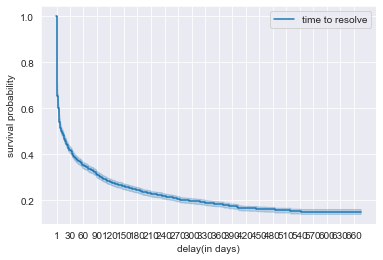

In [10]:
plt.rcParams["figure.figsize"] = (12,4)
kmf1 = KaplanMeierFitter()
a1 = kmf1.fit(durations = time_to_fix, event_observed = observed, label='time to resolve').plot()
ticks = plt.xticks(np.concatenate((np.array([1]), np.arange(30, 690, 30.0)), axis=0))
plt.xlabel("delay(in days)")
plt.ylabel("survival probability")
plt.savefig("survival_analysis_overall.png", dpi=800)

In [19]:
xs = [1, 7, 14, 21, 30, 60, 90, 180, 365]
prob = []
for i in xs:
    prob.append('{:.2f}'.format(kmf1.predict(i)))
res = pd.DataFrame({'x' : xs, 'P(>x)': prob})
res

,x,P(>x)
0,1,0.74
1,7,0.60
2,14,0.57
3,21,0.53
4,30,0.50
5,60,0.43
6,90,0.40
7,180,0.34
8,365,0.26


## Survival Anaylsis: Severity

<lifelines.KaplanMeierFitter:"total", fitted with 4978 total observations, 809 right-censored observations>

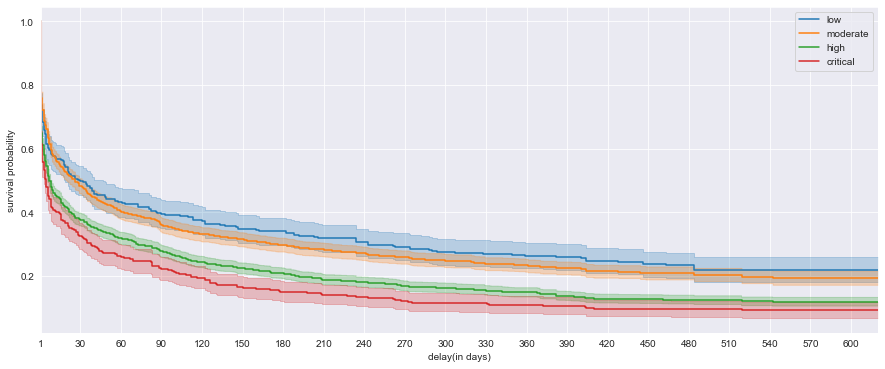

In [20]:
plt.rcParams["figure.figsize"] = (15,6)
## fit the model for 1st cohort
kmf1 = KaplanMeierFitter()
kmf1.fit(df_res[df_res['severity'] == 'LOW']['time_to_fix'],
         df_res[df_res['severity'] == 'LOW']['observed'], label='low')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf2 = KaplanMeierFitter()
kmf2.fit(df_res[df_res['severity'] == 'MODERATE']['time_to_fix'],
         df_res[df_res['severity'] == 'MODERATE']['observed'], label='moderate')
a2 = kmf2.plot(ax=a1)

## fit the model for 3rd cohort
kmf3 = KaplanMeierFitter()
kmf3.fit(df_res[df_res['severity'] == 'HIGH']['time_to_fix'],
         df_res[df_res['severity'] == 'HIGH']['observed'], label='high')
a3 = kmf3.plot(ax=a2)

## fit the model for 4th cohort
kmf4 = KaplanMeierFitter()
kmf4.fit(df_res[df_res['severity'] == 'CRITICAL']['time_to_fix'],
         df_res[df_res['severity'] == 'CRITICAL']['observed'], label='critical')
figure = kmf4.plot(ax=a3)
plt.xlabel("delay(in days)")
plt.ylabel("survival probability")
ticks = plt.xticks(np.concatenate((np.array([1]), np.arange(30, 630, 30.0)), axis=0))
plt.xlim([1, 620])
figure.get_figure().savefig("survival_analysis_severity.png", dpi=800)

# hamid
# total
kmf5 = KaplanMeierFitter()
kmf5.fit(df_res['time_to_fix'], df_res['observed'], label='total')

In [21]:
low_prob = []
mod_prob = []
hig_prob = []
cri_prob = []
total_prob = []
for i in xs:
    low_prob.append('{:.2f}'.format(kmf1.predict(i)))
    mod_prob.append('{:.2f}'.format(kmf2.predict(i)))
    hig_prob.append('{:.2f}'.format(kmf3.predict(i)))
    cri_prob.append('{:.2f}'.format(kmf4.predict(i)))
    total_prob.append('{:.2f}'.format(kmf5.predict(i)))
res = pd.DataFrame({'x' : xs, 'low': low_prob, 'moderate': mod_prob, 'high': hig_prob, 'critical': cri_prob, 'total': total_prob})
res

,x,low,moderate,high,critical,total
0,1,0.74,0.76,0.65,0.62,0.69
1,7,0.60,0.62,0.50,0.44,0.54
2,14,0.57,0.55,0.45,0.40,0.49
3,21,0.53,0.52,0.41,0.36,0.45
4,30,0.50,0.48,0.38,0.33,0.42
5,60,0.43,0.40,0.32,0.26,0.35
6,90,0.40,0.36,0.28,0.22,0.31
7,180,0.34,0.30,0.21,0.15,0.25
8,365,0.26,0.23,0.15,0.11,0.18


In [14]:
for a, b in itertools.combinations(['LOW', 'MODERATE', 'HIGH', 'CRITICAL'], 2):
    test = logrank_test(df_res[df_res['severity'] == a]['time_to_fix'],
                        df_res[df_res['severity'] == b]['time_to_fix'],
                        df_res[df_res['severity'] == a]['observed'],
                        df_res[df_res['severity'] == b]['observed'])
    print('{} ~ {}: {:.3f} (p-value: {}) reject?: {}'.format(
        a, b, 
        test.test_statistic, test.p_value, test.p_value < 0.05/6
    ))

LOW ~ MODERATE: 1.066 (p-value: 0.3018223410763988) reject?: False
LOW ~ HIGH: 35.460 (p-value: 2.602964979507014e-09) reject?: True
LOW ~ CRITICAL: 46.325 (p-value: 1.0016273000344899e-11) reject?: True
MODERATE ~ HIGH: 64.379 (p-value: 1.0266883327716169e-15) reject?: True
MODERATE ~ CRITICAL: 63.464 (p-value: 1.6330279379724703e-15) reject?: True
HIGH ~ CRITICAL: 7.792 (p-value: 0.005248481166124942) reject?: True


## Bot Fix vs Human Fix

In [28]:
groups = []
df_res_group = df_res.merge(pr_nums, how='inner', on=['repository']).copy()
for index, row in df_res_group.iterrows():
    if (row['prs'] > 0) & (row['prs'] < 3):
        groups.append(0)
    elif (row['prs'] > 2) & (row['prs'] < 5):
        groups.append(1)
    elif (row['prs'] > 4) & (row['prs'] < 11):
        groups.append(2)
    elif (row['prs'] > 10) & (row['prs'] < 68):
        groups.append(3)
df_res_group['group'] = groups
df_res_group = df_res_group.sort_values('group')

                       repository  severity  time_to_fix  observed     by  \
4921           sencha/ext-angular       LOW            1      True  human   
3709    facebook/create-react-app  MODERATE           23      True    bot   
3708         digidem/mapeo-mobile  MODERATE            1      True    bot   
3707           daostack/migration  MODERATE            2      True    bot   
3706  danielcaldas/react-d3-graph  MODERATE           13      True    bot   
...                           ...       ...          ...       ...    ...   
2211        redux-form/redux-form      HIGH            1      True  human   
2212        redux-form/redux-form      HIGH            1      True  human   
2213        redux-form/redux-form      HIGH            1      True  human   
1386            vck3000/ProAvalon  MODERATE           35      True    bot   
2205        redux-form/redux-form  MODERATE            1      True    bot   

      prs  group  
4921    1      0  
3709    1      0  
3708    1      0  

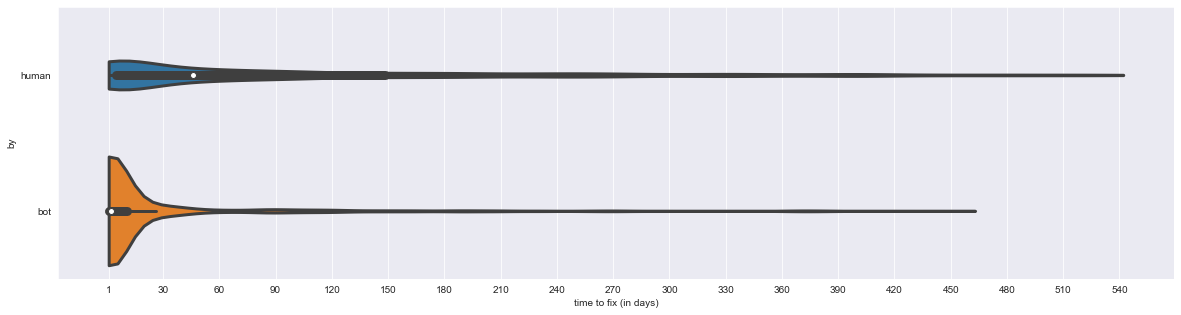

In [25]:
plt.rcParams["figure.figsize"] = (20,5)
ax = sns.violinplot(y='by', x='time_to_fix',
                    data=df_res_group[df_res_group['observed']], cut=0,
                    bw=.15, orient='h', linewidth=3, alpha = 0.4)
ok = plt.xticks(np.concatenate((np.array([1]), np.arange(30, 570, 30.0)), axis=0))
plt.xlabel("time to fix (in days)")
plt.savefig("violin_fixes.png", dpi=800)

In [17]:
mannwhitneyu(df_res_group[(df_res_group['by'] == 'human') & (df_res_group['group'] == 0)]['time_to_fix'],
             df_res_group[(df_res_group['by'] == 'human') & (df_res_group['group'] == 1)]['time_to_fix'])

MannwhitneyuResult(statistic=37711.0, pvalue=8.346114760798313e-05)

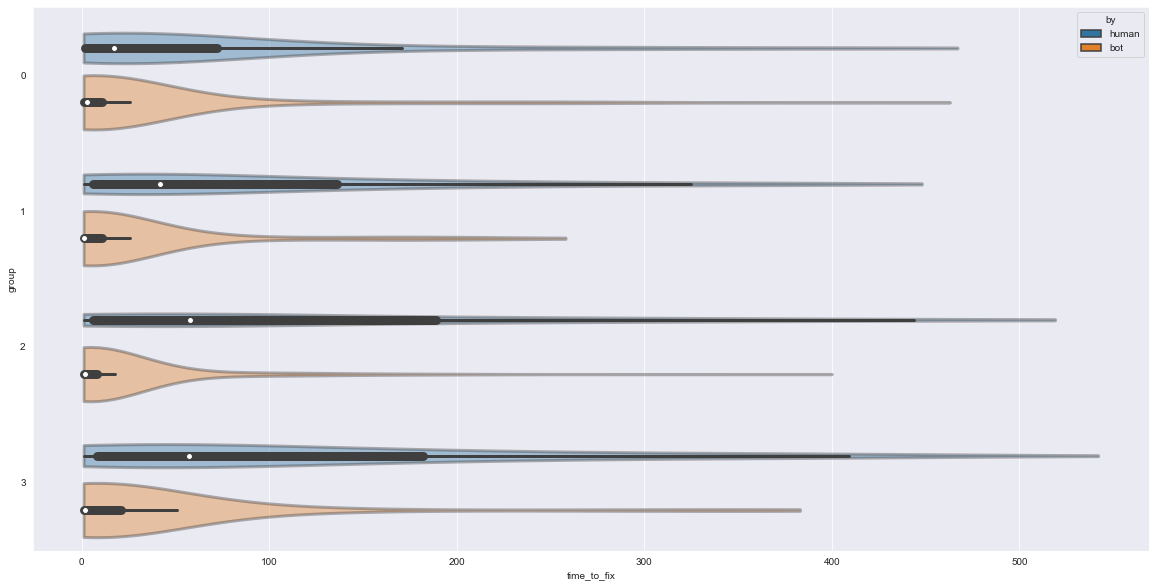

In [47]:
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.violinplot(y='group', x='time_to_fix',
                    data=df_res_group[df_res_group['observed']], cut=0,
                    bw=.65, hue='by', orient='h', linewidth=3,
                    order=[0, 1, 2, 3], alpha = 0.4)

for violin, alpha in zip(ax.collections[::2], range(8)):
    violin.set_alpha(0.4)

In [72]:
by_human = df_res_group[(df_res_group['by'] == 'human')]
by_bot = df_res_group[(df_res_group['by'] == 'bot')]

days = range(60) # 2 month
bot_fix_days = {}
human_fix_days = {}
for i in days:
    bot_fix_days['day-' + str(i)] = len(by_bot[by_bot['time_to_fix'] <= i]) / len(by_bot)
    human_fix_days['day-' + str(i)] = len(by_human[by_human['time_to_fix'] < i]) / len(by_human)

{'day-0': 0.0, 'day-1': 0.46882043576258453, 'day-2': 0.5364387678437266, 'day-3': 0.5807663410969196, 'day-4': 0.6048084147257701, 'day-5': 0.6303531179564238, 'day-6': 0.669045830202855, 'day-7': 0.6930879038317055, 'day-8': 0.7231404958677686, 'day-9': 0.7362885048835462, 'day-10': 0.745679939894816, 'day-11': 0.7535687453042825, 'day-12': 0.7610818933132982, 'day-13': 0.7625845229151015, 'day-14': 0.7659654395191585, 'day-15': 0.7742299023290758, 'day-16': 0.7847483095416979, 'day-17': 0.7903831705484599, 'day-18': 0.7922614575507138, 'day-19': 0.7982719759579263, 'day-20': 0.8016528925619835, 'day-21': 0.8054094665664914, 'day-22': 0.8132982719759579, 'day-23': 0.8170548459804658, 'day-24': 0.8211870773854245, 'day-25': 0.8226897069872277, 'day-26': 0.8275732531930879, 'day-27': 0.8294515401953418, 'day-28': 0.8324567993989481, 'day-29': 0.8395942900075132, 'day-30': 0.8395942900075132, 'day-31': 0.8425995492111195, 'day-32': 0.8441021788129226, 'day-33': 0.8474830954169797, 'day-